## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


---


## Stage 1 : Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 4.6 MB/s 
     |████████████████████████████████| 212 kB 29.3 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


## Stage 2: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val= dataset['validation']
test = dataset['test']

In [ ]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels= [x['label'] for x in data]
  return tweets,labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Stage 3: Tokenizer

1. Tokenizing the tweets


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[24]])

[[2, 208, 3, 14, 2, 506, 42, 137, 37, 2, 88, 430, 524, 33, 36, 12, 6, 237]]

In [ ]:
tweets[24]

'i already feel like i fucked up though because i dont usually eat at all in the morning'

## Stage 4: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

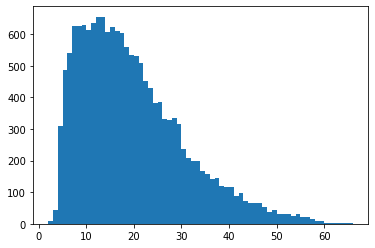

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[24]

array([  2, 208,   3,  14,   2, 506,  42, 137,  37,   2,  88, 430, 524,
        33,  36,  12,   6, 237,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Stage 5 : Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes = set(labels)
print(classes)

{'love', 'joy', 'sadness', 'anger', 'fear', 'surprise'}


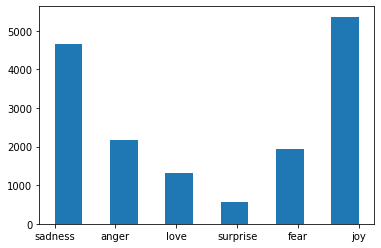

In [ ]:
plt.hist(labels,bins=11)
plt.show()

In [ ]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{'anger': 3, 'fear': 4, 'joy': 1, 'love': 0, 'sadness': 2, 'surprise': 5}

In [ ]:
index_to_class

{0: 'love', 1: 'joy', 2: 'sadness', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)

## Stage 6: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6,activation='softmax')                      
])
model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Stage 7: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [ ]:
from gc import callbacks
h = model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 39s 60ms/step - loss: 1.2749 - accuracy: 0.5047 - val_loss: 0.8149 - val_accuracy: 0.7150
Epoch 2/20
500/500 [==============================] - 28s 56ms/step - loss: 0.5587 - accuracy: 0.8052 - val_loss: 0.4733 - val_accuracy: 0.8385
Epoch 3/20
500/500 [==============================] - 28s 57ms/step - loss: 0.2533 - accuracy: 0.9184 - val_loss: 0.3839 - val_accuracy: 0.8730
Epoch 4/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1585 - accuracy: 0.9497 - val_loss: 0.3793 - val_accuracy: 0.8895
Epoch 5/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1169 - accuracy: 0.9625 - val_loss: 0.3548 - val_accuracy: 0.8945
Epoch 6/20
500/500 [==============================] - 28s 56ms/step - loss: 0.0887 - accuracy: 0.9719 - val_loss: 0.3662 - val_accuracy: 0.8855
Epoch 7/20
500/500 [==============================] - 27s 55ms/step - loss: 0.0749 - accuracy: 0.9766 - val_loss: 0.3642 - val_accuracy:

## Stage 8 : Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

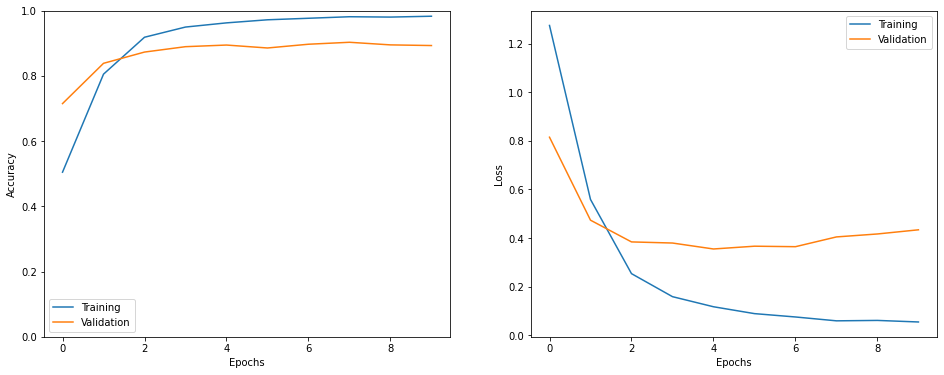

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer,test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.4071 - accuracy: 0.8845


In [ ]:
i = random.randint(0, len(test_labels) - 1)

print('sentence:',test_tweets[i])
print('emotion:',index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype("uint8")]

print('predicted emotion ', pred_class)

sentence: i only do unwillingly and always leaves me feeling grouchy and unsettled
emotion: anger
predicted emotion  anger


In [77]:
preds = model.predict(test_seq)

In [78]:
preds = np.argmax(preds, axis=1)

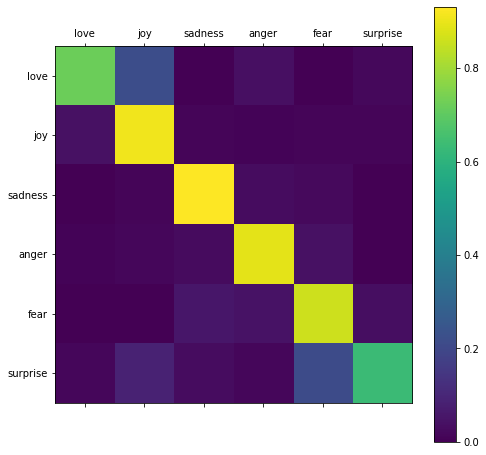

In [79]:
show_confusion_matrix(test_labels,preds,list(classes))